<a href="https://colab.research.google.com/github/surajsarkar/deepLearning/blob/main/notebooks/05_transfer_learning_with_tensor_flow_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer learning with TensorFlow Part-2:  `Fine Tuning`**

In [ ]:
# Check if we are using a gpu
!nvidia-smi

Wed Jun 15 09:00:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Download the helper function**

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-15 16:25:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-15 16:25:30 (97.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-06-15 16:25:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.211.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   239MB/s    in 0.7s    

2022-06-15 16:25:48 (239 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
unzip_data("10_food_classes_10_percent.zip")

In [ ]:
# Check how many directories and sub-directories are there
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [ ]:
# Create training and test directory
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size=IMAGE_SIZE,
                                                                            batch_size=BATCH_SIZE,
                                                                            label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMAGE_SIZE,
                                                                batch_size = BATCH_SIZE,
                                                                label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check the class names.
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# 1. Create a base model with tf.keras.applications

base_model = tf.keras.applications.EfficientNetB0(
    include_top = False, # Specifies if we want to use the top|output layer of pre-trained model or want to add our own top|output layer.
)

# 2. Freeze the base model (so the under-lying pre-trained model aren't updated)
base_model.trainable = False

# 3. Create input layer into our model 
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like Resnet50V2 you will need to normalise inputs (you don't have to nomalise data for Efficientnet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. pass the inputs to the base model 

x = base_model(inputs)

print(f"Shape of the inputs after passing through the base model {x.shape}")

# 6. Average pool the outputs of the base model 
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create a output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the output with a input into a model 
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile a model 
model_0.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# 10. Fit the model 
history_0 = model_0.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=len(test_data),
            callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extraction")])


16719872/16705208 [==============================] - 0s 0us/step
Shape of the inputs after passing through the base model (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220615-162603
Epoch 1/5
24/24 [==============================] - 246s 10s/step - loss: 1.8726 - accuracy: 0.4187 - val_loss: 1.3074 - val_accuracy: 0.7244
Epoch 2/5
24/24 [==============================] - 178s 8s/step - loss: 1.1321 - accuracy: 0.7267 - val_loss: 0.9036 - val_accuracy: 0.8036
Epoch 3/5
24/24 [==============================] - 178s 8s/step - loss: 0.8341 - accuracy: 0.8013 - val_loss: 0.7380 - val_accuracy: 0.8232
Epoch 4/5
24/24 [==============================] - 154s 7s/step - loss: 0.6834 - accuracy: 0.8427 - val_loss: 0.6523 - val_accuracy: 0.8352
Epoch 5/5
24/24 [==============================] - 177s 8s/step - loss: 0.5880 - accuracy: 0.8760 - val_loss: 0.6026 - val_accuracy: 0.8420


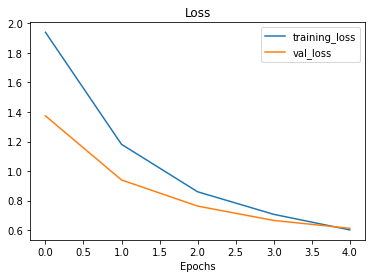

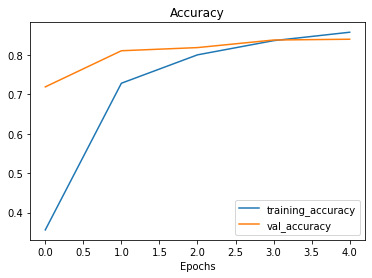

In [ ]:
# Plotting the training curve of model_0
plot_loss_curves(history_0)

In [ ]:
#Evaluate the model

model_0.evaluate(test_data)

79/79 [==============================] - 7s 85ms/step - loss: 0.6126 - accuracy: 0.8396


[0.6125757098197937, 0.8396000266075134]

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


### **Steps to make model with `tf.keras.applications`**

* Create a **Base model**.
* Set the `trainable` property of model to `True` or `False` according to the problem.
* Create a normalization(scaling) layer 
* Create a **Input Layer**.
* Pass the **Input Layer** to base_modle.
* Create a **Global Pooling Layer**.
* Create a **Output Layer**.
* Create a model **`tf.keras.Model(Input Layer, Output Layer)`**.(this returns a `model`)
* Compile the model. 
* Fit the modle.
* Evaluate the model.
* Visualise the `loss curve`.

In [ ]:
tf.__version__

'2.8.2'

### **Looking at `Global Pooling Layer`**


In [ ]:
# Create a random tensor of shape (1, 4, 4, 3)
random_tensor = tf.random.normal(shape=(1, 4, 4, 3))
random_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[-6.8787062e-01,  3.6686096e-01,  1.1759982e+00],
         [-8.9936989e-04,  2.5552249e-01, -5.4824984e-01],
         [-1.3059692e-01, -1.2817367e+00,  3.4300259e-01],
         [-1.8657781e+00, -8.5030597e-01, -1.0676773e+00]],

        [[ 8.7312418e-01,  2.6241452e-01, -1.5548018e+00],
         [-1.7029527e+00,  2.0003450e+00,  1.1876371e+00],
         [-1.4911931e+00,  1.0502450e+00,  1.2586875e+00],
         [-7.0525748e-01,  1.4183155e+00,  1.1549658e+00]],

        [[ 7.5247842e-01, -2.3282534e-01,  2.7835262e-01],
         [ 5.9168428e-01,  7.6520401e-01, -8.7495983e-01],
         [ 7.8733248e-01, -8.5838282e-01, -6.2750912e-01],
         [ 2.0917246e+00, -7.1712279e-01, -1.2828335e-01]],

        [[ 3.3521795e-01,  1.3577661e-01,  2.0572691e-01],
         [ 1.7910650e+00,  1.8113828e+00,  9.1079575e-01],
         [ 8.0701071e-01, -5.8042303e-02, -4.2574611e-02],
         [-4.5280328e-01,  1.4139792e+00,  6.0494035e-0

In [ ]:
# Passing random_tensor to global_average_pooling_layer
pool = tf.keras.layers.GlobalAveragePooling2D()(random_tensor)
pool

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.06201792, 0.34260187, 0.14225319]], dtype=float32)>

In [ ]:
mean_tensor = tf.reduce_mean(random_tensor, axis=[1, 2])
mean_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.06201792, 0.34260187, 0.14225319]], dtype=float32)>

In [ ]:
max_pool = tf.keras.layers.GlobalMaxPooling2D()(random_tensor)
max_pool

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[2.0917246, 2.000345 , 1.2586875]], dtype=float32)>

In [ ]:
max_tensor = tf.reduce_max(random_tensor, axis=[1, 2])
max_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[2.0917246, 2.000345 , 1.2586875]], dtype=float32)>

In [ ]:
tf.reduce_max(random_tensor[0, 0, 3])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.850306>

## Running a series of transfer learning experiments

### Getting and pre-processing data for `model_1`

In [ ]:
# Getting 1% data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-06-15 16:43:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.128, 173.194.213.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   105MB/s    in 1.2s    

2022-06-15 16:43:11 (105 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
unzip_data("10_food_classes_1_percent.zip")

In [ ]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

In [ ]:
# Make data loaders 
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
train_dir_1_percent = "10_food_classes_1_percent/train/"

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMAGE_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model.

To add the data augmenteation right into the model, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers

# Create a augmentation layer
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2)
], name="data_augmentation")

### Visualise our data augmentation layer

(-0.5, 427.5, 330.5, -0.5)

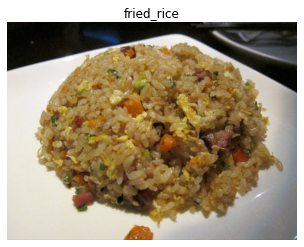

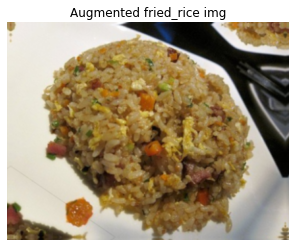

In [ ]:
# View a random image, and compare it to it's augmented image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"{target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented {target_class} img")
plt.axis(False)


## Feature extraction transfer learning on 1% of the data with data augmentation.

In [ ]:
# Create model for 1% data
input_shape = (224, 224, 3)

base_model_1_percent = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_1_percent.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add a data augmnetation sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs and don't train it 
x = base_model_1_percent(x, training=False)

# Pool output feature of the base layer
x = tf.keras.layers.GlobalAveragePooling2D(name="Pool_layer")(x)

# Put a dense layer as a output layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a modle with inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model 
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
            epochs=5,
            steps_per_epoch=len(train_data_1_percent),
            validation_data=test_data,
            validation_steps=len(test_data),
            callbacks = [create_tensorboard_callback("transfer_learning", "1_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/1_percent_feature_extraction/20220615-164316
Epoch 1/5
3/3 [==============================] - 127s 59s/step - loss: 2.4600 - accuracy: 0.0571 - val_loss: 2.2992 - val_accuracy: 0.1412
Epoch 2/5
3/3 [==============================] - 118s 58s/step - loss: 2.2000 - accuracy: 0.2429 - val_loss: 2.1849 - val_accuracy: 0.2124
Epoch 3/5
3/3 [==============================] - 119s 59s/step - loss: 2.0128 - accuracy: 0.3286 - val_loss: 2.0762 - val_accuracy: 0.2900
Epoch 4/5
3/3 [==============================] - 146s 72s/step - loss: 1.8632 - accuracy: 0.4286 - val_loss: 1.9770 - val_accuracy: 0.3596
Epoch 5/5
3/3 [==============================] - 145s 72s/step - loss: 1.6869 - accuracy: 0.5857 - val_loss: 1.8869 - val_accuracy: 0.4200


In [ ]:
model_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Pool_layer (GlobalAveragePo  (None, 1280)             0         
 oling2D)                                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate the test model
model_1.evaluate(test_data)

79/79 [==============================] - 8s 92ms/step - loss: 1.8914 - accuracy: 0.4156


[1.891381859779358, 0.4156000018119812]

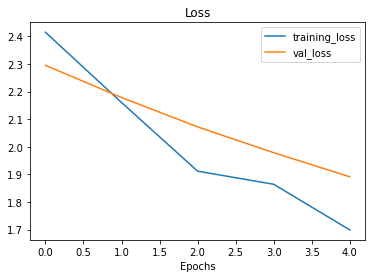

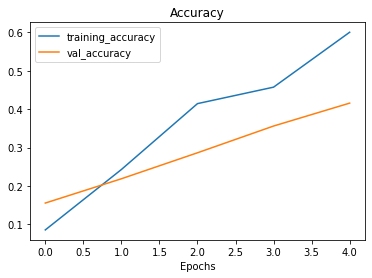

In [ ]:
# Visualise the loss curve
plot_loss_curves(history_1)

### Getting and pre-processing data for `model_2`.

In [ ]:
# Getting 100% data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-06-15 16:55:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   168MB/s    in 2.9s    

2022-06-15 16:55:54 (168 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
unzip_data("10_food_classes_all_data.zip")

In [ ]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.

In [ ]:
# Make data loaders
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_data_10_percent_w_augmentation = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                           label_mode="categorical",
                                                                                           batch_size=32, 
                                                                                           image_size=IMAGE_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                batch_size=32,
                                                                image_size=IMAGE_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create a base model
base_model_10_percent = tf.keras.applications.EfficientNetB0(include_top=False)
# Set trainable to false
base_model_10_percent.trainable = False

# Create a input layer
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# Add augmentation model as a layer
x = data_augmentation(inputs)

# pass the layers to the base model
x = base_model_10_percent(x, training=False)

# Add pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)

# Add a output layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create a model
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model 
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=["accuracy"]
)

# # Fit the model
# history_2 = model_2.fit(train_data_10_percent,
#             epochs=5,
#             steps_per_epoch=len(train_data_10_percent),
#             validation_data=test_data,
#             validation_steps=len(test_data),
#             callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extraction_with_augmentation")])

In [ ]:
# Let's see the summary
model_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate the model 
model_2.evaluate(test_data)

79/79 [==============================] - 7s 72ms/step - loss: 0.7146 - accuracy: 0.8068


[0.7146451473236084, 0.8068000078201294]

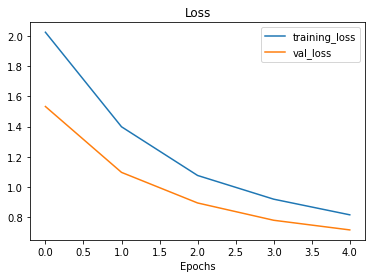

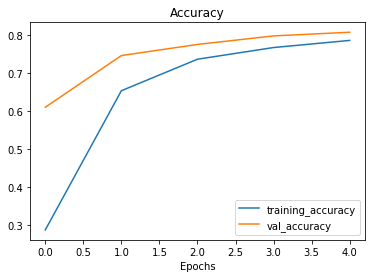

In [ ]:
plot_loss_curves(history_2)

### Creating a modle checkpoint callback

In [ ]:
# Create a model checkpoint callback
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoint_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         sve_best_only=False,
                                                         save_weights_only=True,
                                                         save_freq="epoch", # saves every epoch
                                                         verbose=1)

In [ ]:
# Fit the modle 
history_2 = model_2.fit(
    train_data_10_percent_w_augmentation,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent_w_augmentation),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extraction_with_augmentation"),
               checkpoint_callback],
)

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction_with_augmentation/20220615-170624
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.8364 - accuracy: 0.7773
Epoch 1: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 199s 8s/step - loss: 0.8364 - accuracy: 0.7773 - val_loss: 0.7190 - val_accuracy: 0.8080
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.7671 - accuracy: 0.7907
Epoch 2: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 163s 7s/step - loss: 0.7671 - accuracy: 0.7907 - val_loss: 0.6744 - val_accuracy: 0.8128
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.7023 - accuracy: 0.8173
Epoch 3: saving model to ten_percent_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 182s 8s/step - loss: 0.7023 - accuracy: 0.8173 - val_loss: 0.6333 - val

In [ ]:
# Evaluate the model 
learned_weights_model_2 = model_2.evaluate(test_data)

79/79 [==============================] - 127s 2s/step - loss: 0.5907 - accuracy: 0.8332


### Loading in checkpointed weights

In [ ]:
# Load the save model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)
loaded_weights_model_results 

79/79 [==============================] - 123s 2s/step - loss: 0.5907 - accuracy: 0.8332


[0.5907279849052429, 0.8331999778747559]

# **Fine Tuning**

## Model 3: Fine tuning an existing model on 10% of the data.

In [ ]:
# To begin fine tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model_10_percent.trainable = True
# Un freeze last 10 ten layer.
for layer in base_model_10_percent.layers[:-10]:
  layer.trainable = False

# Recompile 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                metrics=["accuracy"],)


In [ ]:
# Check which layer are tunable.
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
print(len(model_2.trainable_variables))

2


In [ ]:
for i, layer in enumerate(model_2.layers):
  print(i, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 False
3 pooling_layer True
4 output_layer True
